In [1]:
setwd('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1009. NC ENVRIOSCAN/P1009.3. Analyses/P1009.3.6. Kmeans Mapping')
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1009. NC ENVRIOSCAN/P1009.3. Analyses/P1009.3.6. Kmeans Mapping/Output')
cur_date = "031123"

library(readxl)
library(tidyverse)
library(reshape2)
library(sf)
library(tigris)
library(cowplot)
library(rcartocolor)
library(RColorBrewer)
library(MetBrewer)

# reading in files
whp_df = data.frame(read_excel("Input/Imputed_Wildfire_Hazard_030923.xlsx"))
ej_screen_geo_id_clusters = data.frame(read_excel("Input/GEO_ID_Sociodemographic_WHP_Clusters_030923.xlsx"))
housing_geo_id_clusters = data.frame(read_excel("Input/GEO_ID_Housing_WHP_Clusters_030923.xlsx"))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Linking to GEOS 3.11.0, GDAL 3.5.2, PROJ 9.0.1; sf_use_s2() is TRUE


Linked against: 3.11.0-CAPI-1.17.0 compiled against: 3.10.3-CAPI-1.16.1

It is probably a good idea to reinstall sf, and maybe rgeos and rgdal too

To enable caching of data, set `options(tigris_use_cache = TRUE)`
in your R script or .Rprofile.



In [2]:
head(whp_df)

,GEO_ID,FIPS,County,Census_Tract,Avg_ACRES,Wildfire_Hazard_Potential_Mean,Wildfire_Hazard_Potential_Quintile_Number,Wildfire_Hazard_Potential_Quintile_Percentage
,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,14000US37141920201,37141920201,Pender,9202.01,596842.6,715.5177,5,0-20%
2,14000US37141920401,37141920401,Pender,9204.01,596842.6,715.5177,5,0-20%
3,14000US37141920402,37141920402,Pender,9204.02,596842.6,715.5177,5,0-20%
4,14000US37141920403,37141920403,Pender,9204.03,596842.6,715.5177,5,0-20%
5,14000US37141920601,37141920601,Pender,9206.01,596842.6,715.5177,5,0-20%
6,14000US37141990100,37141990100,Pender,9901.00,596842.6,715.5177,5,0-20%


In [3]:
# download shapefile from the tigris (census package)
nc_census_tract_shapefile = tracts(state = 37, year = 2010) %>%
    rename(FIPS = GEOID10)
# nc_county_shapefile = counties(state = 37, year = 2010) %>%
#     rename(FIPS = GEOID10)
head(nc_census_tract_shapefile)

  |======================================================================| 100%


Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



,STATEFP10,COUNTYFP10,TRACTCE10,FIPS,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,COUNTYFP,STATEFP,geometry
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<MULTIPOLYGON [°]>
1,37,153,970100,37153970100,9701,Census Tract 9701,G5020,S,246281647,2106825,+35.0503203,-079.6180454,153,37,MULTIPOLYGON (((-79.56729 3...
2,37,153,970200,37153970200,9702,Census Tract 9702,G5020,S,457736198,7835811,+35.0967892,-079.8225512,153,37,MULTIPOLYGON (((-79.71753 3...
3,37,153,970800,37153970800,9708,Census Tract 9708,G5020,S,139358521,2752112,+34.8508484,-079.8201950,153,37,MULTIPOLYGON (((-79.76773 3...
4,37,153,970900,37153970900,9709,Census Tract 9709,G5020,S,23311020,78240,+34.8785679,-079.7346295,153,37,MULTIPOLYGON (((-79.76773 3...
5,37,153,971000,37153971000,9710,Census Tract 9710,G5020,S,49233222,188190,+34.9395795,-079.6628977,153,37,MULTIPOLYGON (((-79.69038 3...
6,37,153,971100,37153971100,9711,Census Tract 9711,G5020,S,161136716,948938,+34.8751742,-079.6567146,153,37,MULTIPOLYGON (((-79.5684 34...


In [4]:
# first changing data type of some of the columns
whp_df$FIPS = as.character(whp_df$FIPS)
ej_screen_geo_id_clusters$Cluster = as.character(ej_screen_geo_id_clusters$Cluster)
housing_geo_id_clusters$Cluster = as.character(housing_geo_id_clusters$Cluster)

# combining data
all_data_census_tract = full_join(whp_df, nc_census_tract_shapefile)
all_data_census_tract$Wildfire_Hazard_Potential_Quintile_Number = as.character(all_data_census_tract$Wildfire_Hazard_Potential_Quintile_Number)

head(all_data_census_tract)

Joining, by = "FIPS"


,GEO_ID,FIPS,County,Census_Tract,Avg_ACRES,Wildfire_Hazard_Potential_Mean,Wildfire_Hazard_Potential_Quintile_Number,Wildfire_Hazard_Potential_Quintile_Percentage,STATEFP10,COUNTYFP10,⋯,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,COUNTYFP,STATEFP,geometry
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<MULTIPOLYGON [°]>
1,14000US37141920201,37141920201,Pender,9202.01,596842.6,715.5177,5,0-20%,37,141,⋯,Census Tract 9202.01,G5020,S,21147417,44942,+34.4018480,-077.6218025,141,37,MULTIPOLYGON (((-77.66061 3...
2,14000US37141920401,37141920401,Pender,9204.01,596842.6,715.5177,5,0-20%,37,141,⋯,Census Tract 9204.01,G5020,S,75755882,15209,+34.5055979,-077.9462191,141,37,MULTIPOLYGON (((-77.94007 3...
3,14000US37141920402,37141920402,Pender,9204.02,596842.6,715.5177,5,0-20%,37,141,⋯,Census Tract 9204.02,G5020,S,65209545,12064,+34.5702392,-077.9912005,141,37,MULTIPOLYGON (((-77.92338 3...
4,14000US37141920403,37141920403,Pender,9204.03,596842.6,715.5177,5,0-20%,37,141,⋯,Census Tract 9204.03,G5020,S,106488713,1076000,+34.5493899,-077.8690183,141,37,MULTIPOLYGON (((-77.83308 3...
5,14000US37141920601,37141920601,Pender,9206.01,596842.6,715.5177,5,0-20%,37,141,⋯,Census Tract 9206.01,G5020,S,103459422,348628,+34.4486577,-077.9634232,141,37,MULTIPOLYGON (((-77.94027 3...
6,14000US37141990100,37141990100,Pender,9901.00,596842.6,715.5177,5,0-20%,37,141,⋯,Census Tract 9901,G5020,S,0,133298842,+34.3492469,-077.6031266,141,37,MULTIPOLYGON (((-77.67696 3...


Creating 3 different maps of North Carolina:

1. WHP mean by GEO id
2. Clusters based on EJ Screen social stressors and WHP by GEO id
3. Clusters based on housing and WHP data by GEO id

# WHP Mean by GEO id

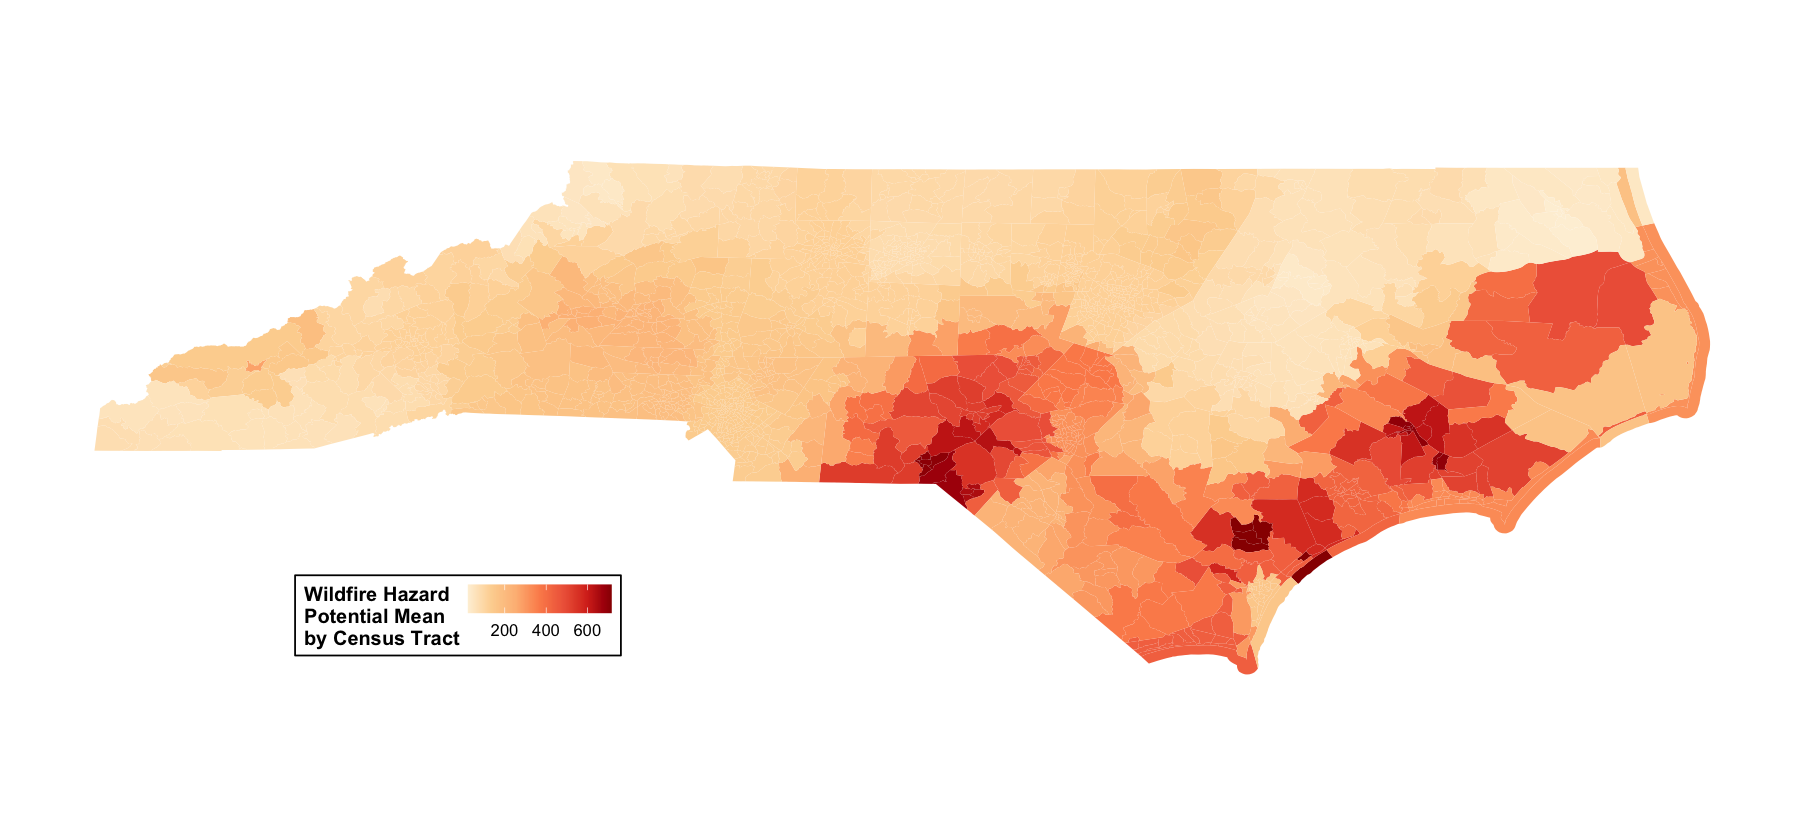

In [5]:
options(repr.plot.width = 15, repr.plot.height = 7) #changing size

# getting color palette
palette_colors = brewer.pal(7, "OrRd")

WHP_mean_GEO_ID_map = ggplot() +
  geom_sf(data = all_data_census_tract, aes(fill = Wildfire_Hazard_Potential_Mean, geometry = geometry), 
          color = NA) + # removes gray lines between geo ids

  theme_bw() + 

  theme(axis.text = element_blank(), # removes x and y labels
      axis.ticks = element_blank(),# removes ticks from x and y labels
      legend.title = element_text(face = 'bold', size = 12), # changes legend title
      legend.text = element_text(size = 10), # changes legend text
      legend.position = c(0.25,0.15), # move legend to bottom left corner
      legend.direction = "horizontal",
      legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
      panel.border = element_blank(), # removes border around the map
      panel.grid.major = element_blank(), # removes grid
      panel.grid.minor = element_blank()) + # removes grid 
  
  scale_fill_gradientn(colors = palette_colors, 
                       na.value = "black", # making geo ids w/ NA values black
      name = "Wildfire Hazard\nPotential Mean\nby Census Tract")

WHP_mean_GEO_ID_map

# GEO ID clustering using EJ Screen Indicators

In [6]:
# adding in clusters
ej_screen_df = full_join(all_data_census_tract, ej_screen_geo_id_clusters)

head(ej_screen_df)

Joining, by = "GEO_ID"


,GEO_ID,FIPS,County,Census_Tract,Avg_ACRES,Wildfire_Hazard_Potential_Mean,Wildfire_Hazard_Potential_Quintile_Number,Wildfire_Hazard_Potential_Quintile_Percentage,STATEFP10,COUNTYFP10,⋯,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,COUNTYFP,STATEFP,geometry,Cluster
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<MULTIPOLYGON [°]>,<chr>
1,14000US37141920201,37141920201,Pender,9202.01,596842.6,715.5177,5,0-20%,37,141,⋯,G5020,S,21147417,44942,+34.4018480,-077.6218025,141,37,MULTIPOLYGON (((-77.66061 3...,3
2,14000US37141920401,37141920401,Pender,9204.01,596842.6,715.5177,5,0-20%,37,141,⋯,G5020,S,75755882,15209,+34.5055979,-077.9462191,141,37,MULTIPOLYGON (((-77.94007 3...,2
3,14000US37141920402,37141920402,Pender,9204.02,596842.6,715.5177,5,0-20%,37,141,⋯,G5020,S,65209545,12064,+34.5702392,-077.9912005,141,37,MULTIPOLYGON (((-77.92338 3...,2
4,14000US37141920403,37141920403,Pender,9204.03,596842.6,715.5177,5,0-20%,37,141,⋯,G5020,S,106488713,1076000,+34.5493899,-077.8690183,141,37,MULTIPOLYGON (((-77.83308 3...,3
5,14000US37141920601,37141920601,Pender,9206.01,596842.6,715.5177,5,0-20%,37,141,⋯,G5020,S,103459422,348628,+34.4486577,-077.9634232,141,37,MULTIPOLYGON (((-77.94027 3...,1
6,14000US37141990100,37141990100,Pender,9901.00,596842.6,715.5177,5,0-20%,37,141,⋯,G5020,S,0,133298842,+34.3492469,-077.6031266,141,37,MULTIPOLYGON (((-77.67696 3...,NA


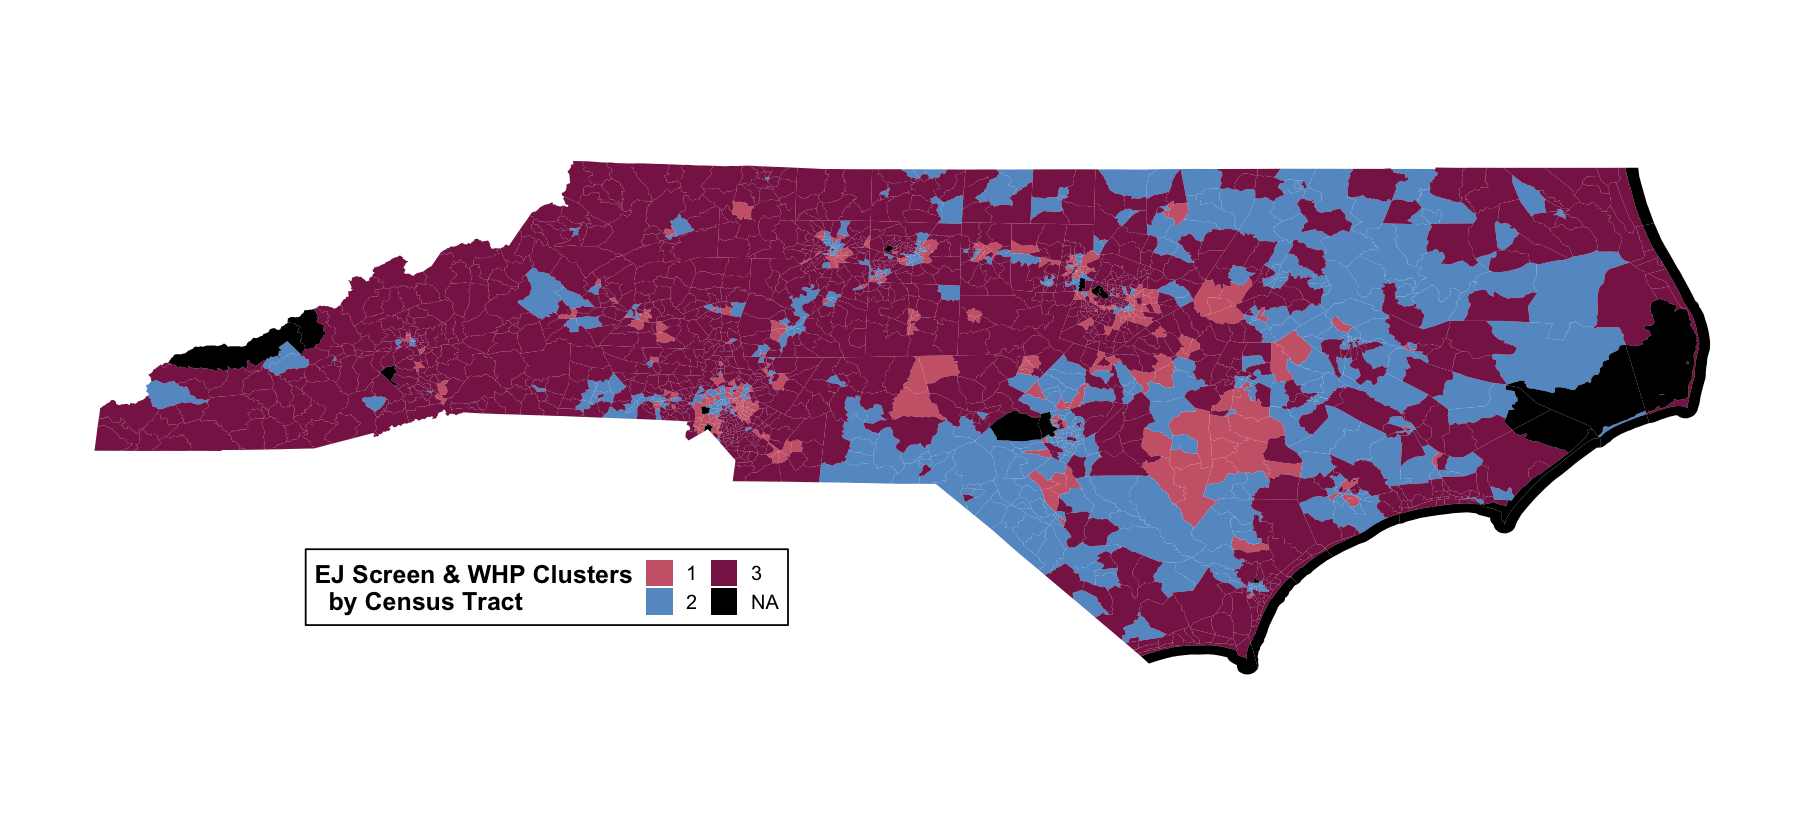

In [7]:
options(repr.plot.width=15, repr.plot.height=7) #changing size

# getting color palette
prism_colors = carto_pal(12, "Safe")

ej_screen_GEO_ID_map = ggplot() +
  geom_sf(data = ej_screen_df, aes(fill = Cluster, geometry = geometry), 
          color = NA) + # removes gray lines between geo ids

  theme_bw() + 

    theme(axis.text = element_blank(), # removes x and y labels
      axis.ticks = element_blank(),# removes ticks from x and y labels
      legend.title = element_text(face = 'bold', size = 15), # changes legend title
      legend.text = element_text(size = 12), # changes legend text
      legend.position = c(0.3,0.2), # move legend to bottom left corner
      legend.direction = "horizontal",
      legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
      panel.border = element_blank(), # removes border around the map
      panel.grid.major = element_blank(), # removes grid
      panel.grid.minor = element_blank()) + # removes grid 

  scale_fill_manual(values = prism_colors[c(2,11,9)], #peru_palette[c(2,3,5,6)],
                    na.value = "black", # making geo ids w/ NA values black
                    name = "EJ Screen & WHP Clusters\n  by Census Tract") + 

  guides(fill = guide_legend(nrow = 2)) # making the quintiles in the legend into rows



ej_screen_GEO_ID_map

# GEO ID clustering using Housing Indicators

In [8]:
# adding in clusters
housing_clusters_geometry_df = full_join(all_data_census_tract, housing_geo_id_clusters)
head(housing_clusters_geometry_df)

Joining, by = "GEO_ID"


,GEO_ID,FIPS,County,Census_Tract,Avg_ACRES,Wildfire_Hazard_Potential_Mean,Wildfire_Hazard_Potential_Quintile_Number,Wildfire_Hazard_Potential_Quintile_Percentage,STATEFP10,COUNTYFP10,⋯,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,COUNTYFP,STATEFP,geometry,Cluster
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<MULTIPOLYGON [°]>,<chr>
1,14000US37141920201,37141920201,Pender,9202.01,596842.6,715.5177,5,0-20%,37,141,⋯,G5020,S,21147417,44942,+34.4018480,-077.6218025,141,37,MULTIPOLYGON (((-77.66061 3...,1
2,14000US37141920401,37141920401,Pender,9204.01,596842.6,715.5177,5,0-20%,37,141,⋯,G5020,S,75755882,15209,+34.5055979,-077.9462191,141,37,MULTIPOLYGON (((-77.94007 3...,1
3,14000US37141920402,37141920402,Pender,9204.02,596842.6,715.5177,5,0-20%,37,141,⋯,G5020,S,65209545,12064,+34.5702392,-077.9912005,141,37,MULTIPOLYGON (((-77.92338 3...,1
4,14000US37141920403,37141920403,Pender,9204.03,596842.6,715.5177,5,0-20%,37,141,⋯,G5020,S,106488713,1076000,+34.5493899,-077.8690183,141,37,MULTIPOLYGON (((-77.83308 3...,1
5,14000US37141920601,37141920601,Pender,9206.01,596842.6,715.5177,5,0-20%,37,141,⋯,G5020,S,103459422,348628,+34.4486577,-077.9634232,141,37,MULTIPOLYGON (((-77.94027 3...,1
6,14000US37141990100,37141990100,Pender,9901.00,596842.6,715.5177,5,0-20%,37,141,⋯,G5020,S,0,133298842,+34.3492469,-077.6031266,141,37,MULTIPOLYGON (((-77.67696 3...,NA


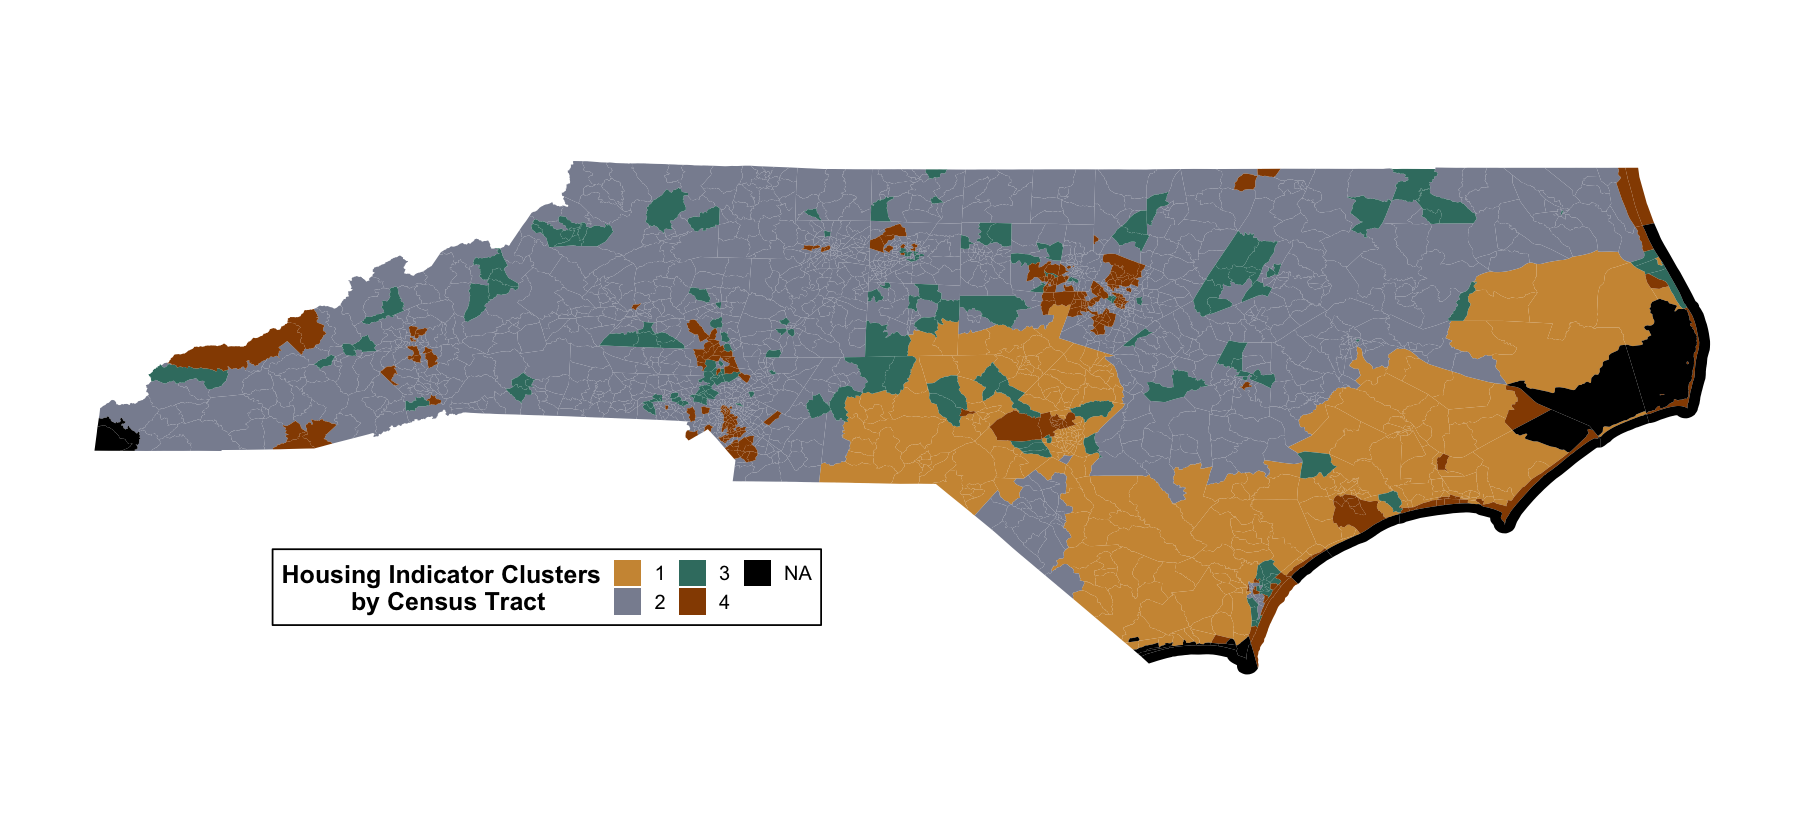

In [9]:
# getting color palette
peru_palette = MetPalettes$Kandinsky[[1]]

housing_GEO_ID_map = ggplot() +
  geom_sf(data = housing_clusters_geometry_df, aes(fill = Cluster, geometry = geometry), 
          color = NA) + # removes gray lines between geo ids

  theme_bw() + 

    theme(axis.text = element_blank(), # removes x and y labels
      axis.ticks = element_blank(),# removes ticks from x and y labels
      legend.title = element_text(face = 'bold', size = 15), # changes legend title
      legend.text = element_text(size = 12), # changes legend text
      legend.position = c(0.3,0.2), # move legend to bottom left corner
      legend.direction = "horizontal",
      legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
      panel.border = element_blank(), # removes border around the map
      panel.grid.major = element_blank(), # removes grid
      panel.grid.minor = element_blank()) + # removes grid 

  scale_fill_manual(values = c(peru_palette[2], peru_palette[c(3,1)], "#964B00"),
                    na.value = "black", # making geo ids w/ NA values black
                    name = "Housing Indicator Clusters\n          by Census Tract") + 

  guides(fill = guide_legend(nrow = 2)) # making the quintiles in the legend into rows



housing_GEO_ID_map

# Which areas have high social stress, detrimental housing outcomes, and high WHP?

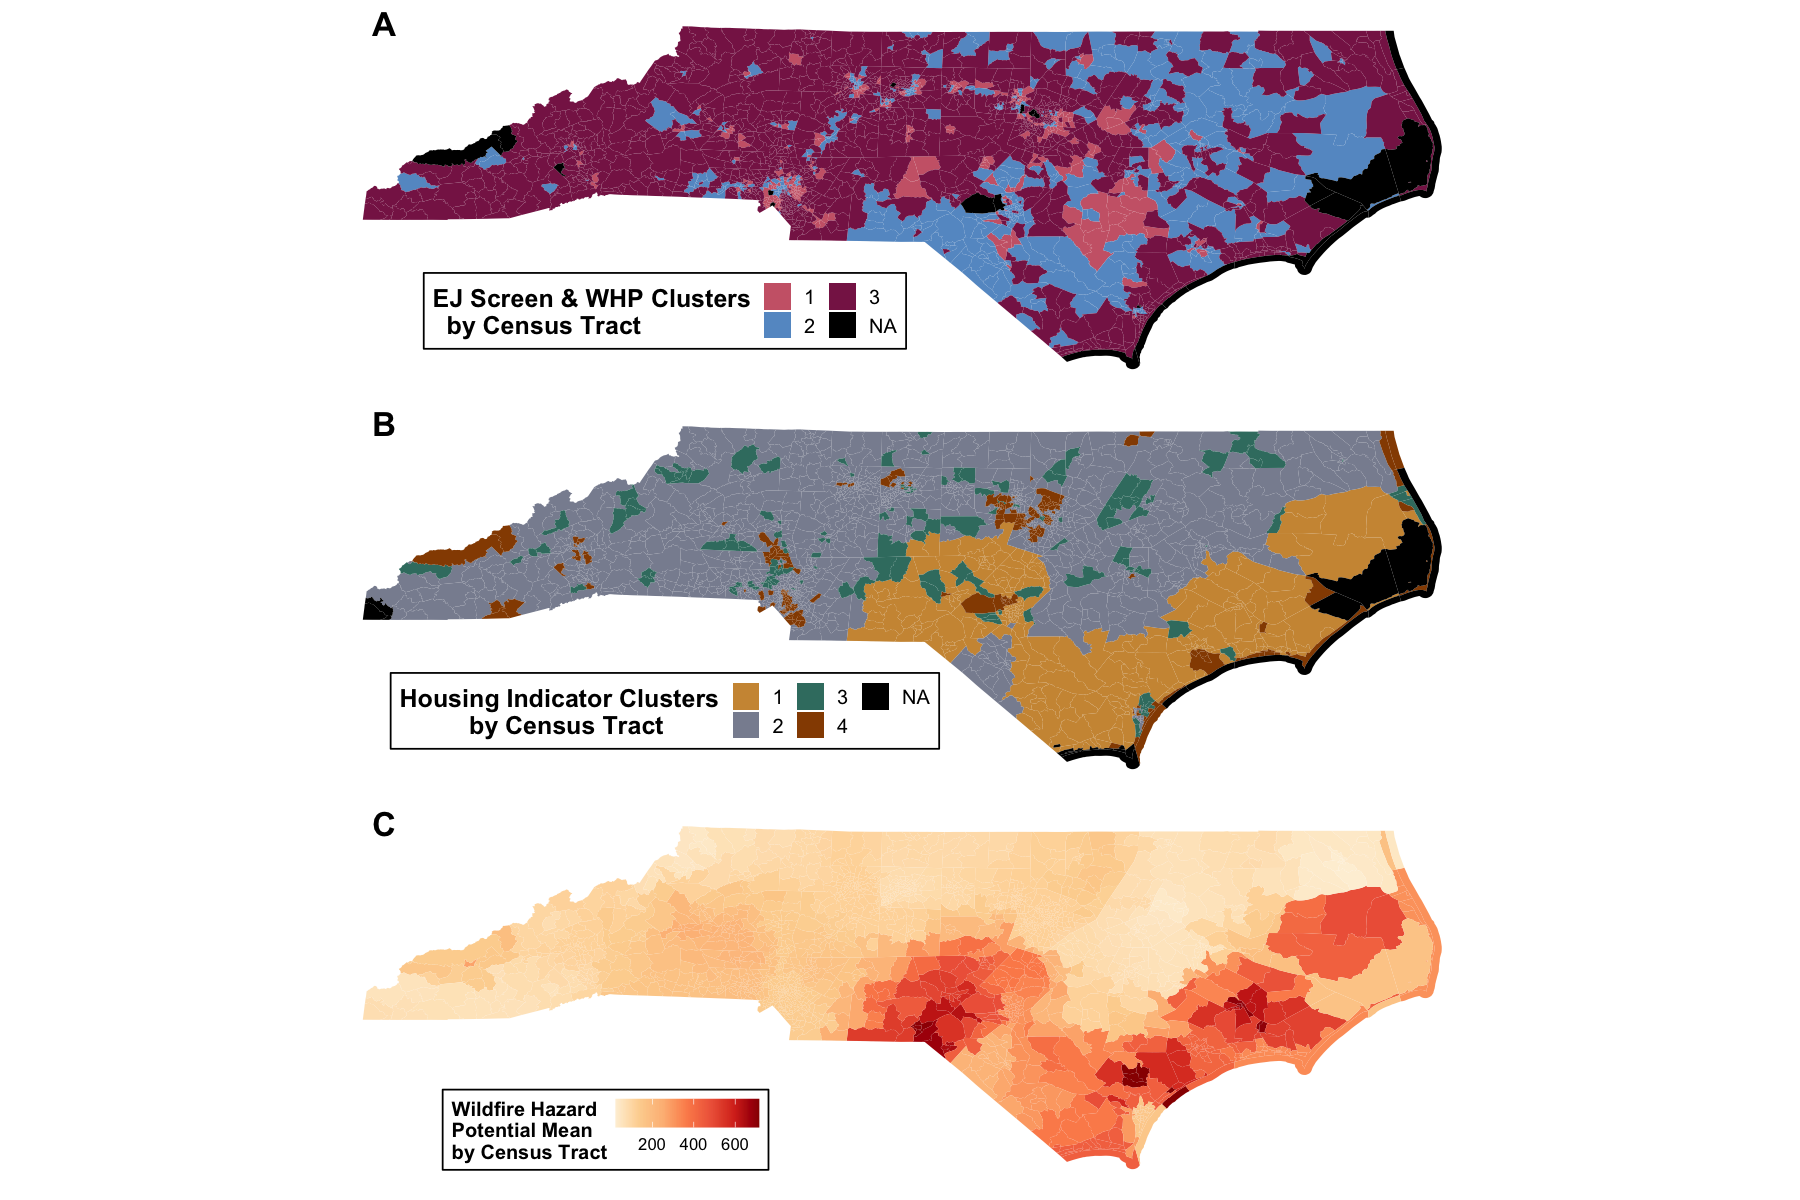

In [10]:
options(repr.plot.width = 15, repr.plot.height = 10) #changing size
ej_screen_housing_whp_figure = plot_grid(ej_screen_GEO_ID_map, housing_GEO_ID_map, WHP_mean_GEO_ID_map, ncol = 1,
                            # adding labels, changing size their size and position
                            labels = "AUTO", label_size = 20, label_x = 0.2)

ej_screen_housing_whp_figure

Not really, but we also don't yet know the directionality of the sociodemographic variables that are driving the clusters.

In [11]:
# exporting figure
ggsave(ej_screen_housing_whp_figure, 
       filename = 'Figure (with WHP).pdf',
       path = Output,
       width = 15, height = 10)